In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# kaggle.json'u drive'dan alınır
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Kaggle'dan veri setini indirilir
!kaggle datasets download -d orvile/brain-cancer-mri-dataset

import zipfile
with zipfile.ZipFile("brain-cancer-mri-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("brain_mri_data")

Dataset URL: https://www.kaggle.com/datasets/orvile/brain-cancer-mri-dataset
License(s): CC-BY-SA-4.0
brain-cancer-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from collections import Counter

In [ ]:
data_dir = '/content/brain_mri_data/Brain_Cancer raw MRI data/Brain_Cancer'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz: {device}")


Cihaz: cuda


In [ ]:
# Eğitim verisi için augmentation uygulanmış transform
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),

    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


# Doğrulama ve test için sadece normalize
test_val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [ ]:
# Tüm veri seti bir kez yüklenir
full_dataset = datasets.ImageFolder(root=data_dir)

# Dataseti bölünür
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_data, val_data, test_data = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Her parçaya uygun transform ayrı ayrı atanır
train_data.dataset.transform = train_transform
val_data.dataset.transform = test_val_transform
test_data.dataset.transform = test_val_transform


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = full_dataset.classes
print("Sınıflar:", class_names)
num_classes = len(class_names)

Sınıflar: ['brain_glioma', 'brain_menin', 'brain_tumor']


In [ ]:
# Görüntü sayıları
targets = full_dataset.targets

class_counts = Counter(targets)

for idx, count in class_counts.items():
    print(f"{class_names[idx]}: {count} görüntü")


brain_glioma: 2004 görüntü
brain_menin: 2004 görüntü
brain_tumor: 2048 görüntü


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),      # (1, 224, 224) -> (32, 224, 224)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                    # -> (32, 112, 112)

            nn.Conv2d(32, 64, 3, padding=1),    # -> (64, 112, 112)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                    # -> (64, 56, 56)

            nn.Conv2d(64, 128, 3, padding=1),   # -> (128, 56, 56)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                    # -> (128, 28, 28)

            nn.Conv2d(128, 256, 3, padding=1),  # -> (256, 28, 28)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)                     # -> (256, 14, 14)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # -> (256, 1, 1)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                      # -> (256,)
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_pool(x)
        x = self.fc_layers(x)
        return x

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, patience=10):
    train_acc, val_acc = [], []
    train_losses, val_losses = [], []

    best_val_acc = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)

        # Doğrulama
        model.eval()
        correct, total = 0, 0
        running_val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        scheduler.step(val_loss)

        current_lr=optimizer.param_groups[0]['lr']
        print(f"[Epoch {epoch+1:02d}/{epochs}] "
              f"🟢 Train Acc: {train_accuracy:.4f} | Loss: {train_loss:.4f} || "
              f"🔵 Val Acc: {val_accuracy:.4f} | Loss: {val_loss:.4f} |"
              f"Current learning rate: {current_lr}")

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⏹️ Erken durdurma uygulandı. {epoch+1}. epoch'tan sonra gelişme olmadı.")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_acc, val_acc, train_losses, val_losses


In [ ]:
# Sınıf sayısı veri setinden alınır
num_classes = len(class_names)

# Model oluşturulur ve cihaza taşınır
model = CNNModel(num_classes).to(device)

# Kayıp fonksiyonu ve optimizer tanımlanır
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
)

# Eğitim fonksiyonu çağırılır
train_acc, val_acc, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50
)


[Epoch 01/50] 🟢 Train Acc: 0.7846 | Loss: 0.5206 || 🔵 Val Acc: 0.7533 | Loss: 0.5661 |Current learning rate: 0.001
[Epoch 02/50] 🟢 Train Acc: 0.8728 | Loss: 0.3329 || 🔵 Val Acc: 0.6575 | Loss: 1.1357 |Current learning rate: 0.001
[Epoch 03/50] 🟢 Train Acc: 0.9066 | Loss: 0.2618 || 🔵 Val Acc: 0.3524 | Loss: 3.0298 |Current learning rate: 0.001
[Epoch 04/50] 🟢 Train Acc: 0.9125 | Loss: 0.2529 || 🔵 Val Acc: 0.5220 | Loss: 1.5090 |Current learning rate: 0.0005
[Epoch 05/50] 🟢 Train Acc: 0.9382 | Loss: 0.1783 || 🔵 Val Acc: 0.6289 | Loss: 1.3405 |Current learning rate: 0.0005
[Epoch 06/50] 🟢 Train Acc: 0.9377 | Loss: 0.1602 || 🔵 Val Acc: 0.8040 | Loss: 0.5397 |Current learning rate: 0.0005
[Epoch 07/50] 🟢 Train Acc: 0.9568 | Loss: 0.1337 || 🔵 Val Acc: 0.8557 | Loss: 0.3340 |Current learning rate: 0.0005
[Epoch 08/50] 🟢 Train Acc: 0.9568 | Loss: 0.1211 || 🔵 Val Acc: 0.8546 | Loss: 0.3678 |Current learning rate: 0.0005
[Epoch 09/50] 🟢 Train Acc: 0.9573 | Loss: 0.1195 || 🔵 Val Acc: 0.7291 | Los

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print(f"\nTest Doğruluğu: {acc:.4f}")

evaluate(model, test_loader)


Test Doğruluğu: 0.9901


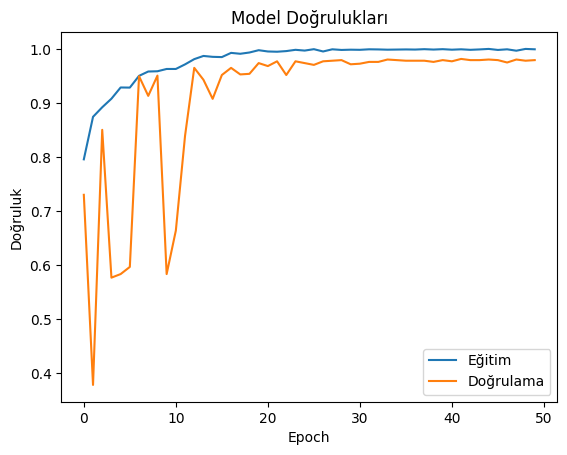

In [ ]:
plt.plot(train_acc, label='Eğitim')
plt.plot(val_acc, label='Doğrulama')
plt.title("Model Doğrulukları")
plt.xlabel("Epoch")
plt.ylabel("Doğruluk")
plt.legend()
plt.show()


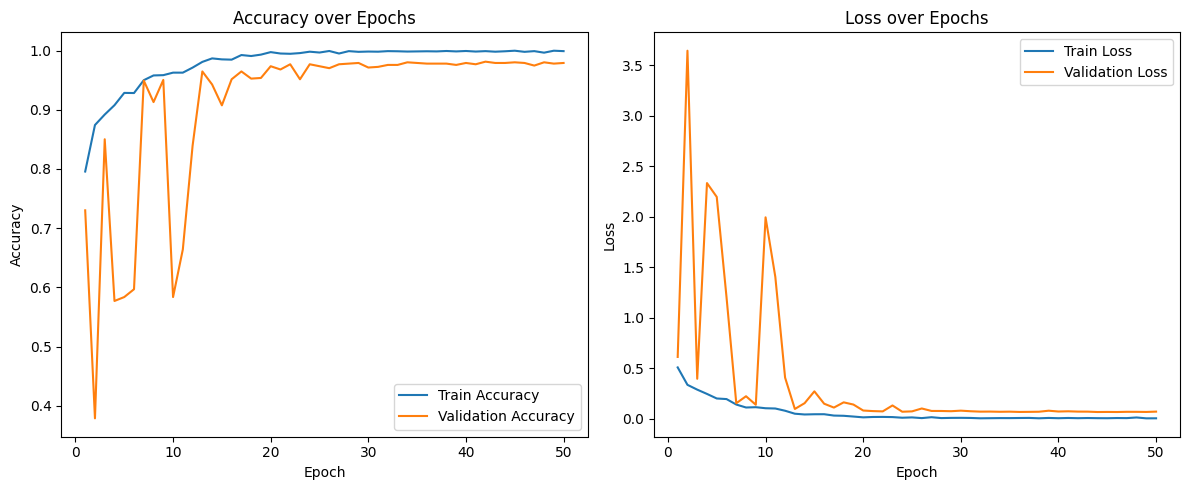

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_acc, val_acc, train_losses, val_losses)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def evaluate_confusion(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Sınıf Bazlı Rapor
    print("\n📋 Sınıf Bazlı Performans:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Matris Görselleştirme
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title('🔍 Confusion Matrix')
    plt.tight_layout()
    plt.show()



📋 Sınıf Bazlı Performans:

              precision    recall  f1-score   support

brain_glioma       1.00      0.99      0.99       292
 brain_menin       0.99      0.98      0.99       302
 brain_tumor       0.98      0.99      0.99       315

    accuracy                           0.99       909
   macro avg       0.99      0.99      0.99       909
weighted avg       0.99      0.99      0.99       909



<ipython-input-38-190961244>:28: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


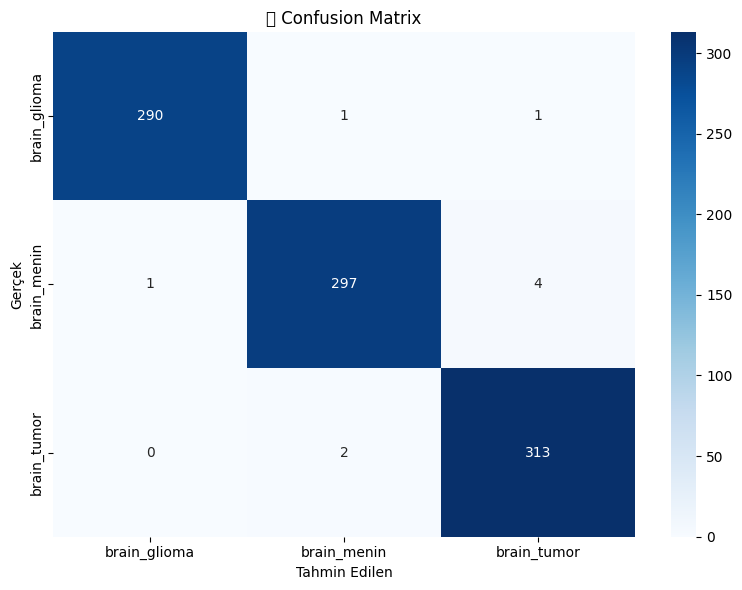

In [ ]:
evaluate_confusion(model, test_loader, class_names)


In [ ]:
save_path = "/content/drive/MyDrive/en_iyi_model1.pth"

torch.save(model.state_dict(), save_path)

print(f"✅ Model Drive'a kaydedildi: {save_path}")


✅ Model Drive'a kaydedildi: /content/drive/MyDrive/en_iyi_model1.pth
